In [458]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [459]:
def resize_image_aspect(image, new_width=400):
    h, w = image.shape[:2]
    aspect_ratio = h / w
    new_height = int(new_width * aspect_ratio)
    resized = cv2.resize(image, (new_width, new_height))
    return resized

In [460]:
image_path = "Input Image path"  # Replace with your image path
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = resize_image_aspect(image, new_width=400)

In [461]:
def k_means_segmentation(image, k=3, apply_distance=False):
    if k <= 0:
        raise ValueError("K must be greater than 0 for k-means clustering.")

    h, w, c = image.shape
    reshaped = image.reshape((-1, 3)).astype(np.float32)

    if apply_distance:
        grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))
        distance = np.sqrt((grid_x - w//2)**2 + (grid_y - h//2)**2).reshape(-1, 1)
        reshaped = np.hstack([reshaped, distance]).astype(np.float32)
    
    reshaped = reshaped[:, :3]
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.2)
    _, labels, centers = cv2.kmeans(reshaped, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers[:, :3])
    segmented_image = centers[labels.flatten()].reshape((h, w, c))

    return segmented_image

In [2]:
def draw_rectangle(image):
    rect = (50, 50, 300, 300)  # (x, y, width, height)
    marked_image = image.copy()
    cv2.rectangle(marked_image, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (255, 0, 0), 2)
    return marked_image

#I know it won't be in the center but for some reason the center bounding box code doesn't work
#Try the below if you want for automatic bounding box
'''
def draw_rectangle(image, scale=0.75):
    h, w = image.shape[:2]
    rect_width = int(w * scale)
    rect_height = int(h * scale)
    x = (w - rect_width) // 2
    y = (h - rect_height) // 2
    return (x, y, rect_width, rect_height)

'''

''

In [463]:
def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    sure_bg = cv2.dilate(binary, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    markers = markers.astype(np.int32)  # ✅ Fix watershed markers

    image_copy = image.copy()
    cv2.watershed(image_copy, markers)
    image_copy[markers == -1] = [255, 0, 0]  # Mark boundaries in red

    return image_copy

In [464]:
def graph_cut_segmentation(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    rect = get_center_rectangle(image)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
    segmented_image = image * mask2[:, :, np.newaxis]
    segmented_image_rgba = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2RGBA)
    segmented_image_rgba[:, :, 3] = mask2 * 255

    return segmented_image_rgba

def get_center_rectangle(image, scale=0.75):
    h, w = image.shape[:2]
    rect_width = int(w * scale)
    rect_height = int(h * scale)
    x = (w - rect_width) // 2
    y = (h - rect_height) // 2
    return (x, y, rect_width, rect_height)

In [465]:
# Apply each segmentation method
kmeans_1 = k_means_segmentation(image, k=3, apply_distance=False)
kmeans_2 = draw_rectangle(k_means_segmentation(image, k=3, apply_distance=False))
kmeans_3 = k_means_segmentation(image, k=3, apply_distance=True)
watershed_result = watershed_segmentation(image)
graph_cut_result = graph_cut_segmentation(image)

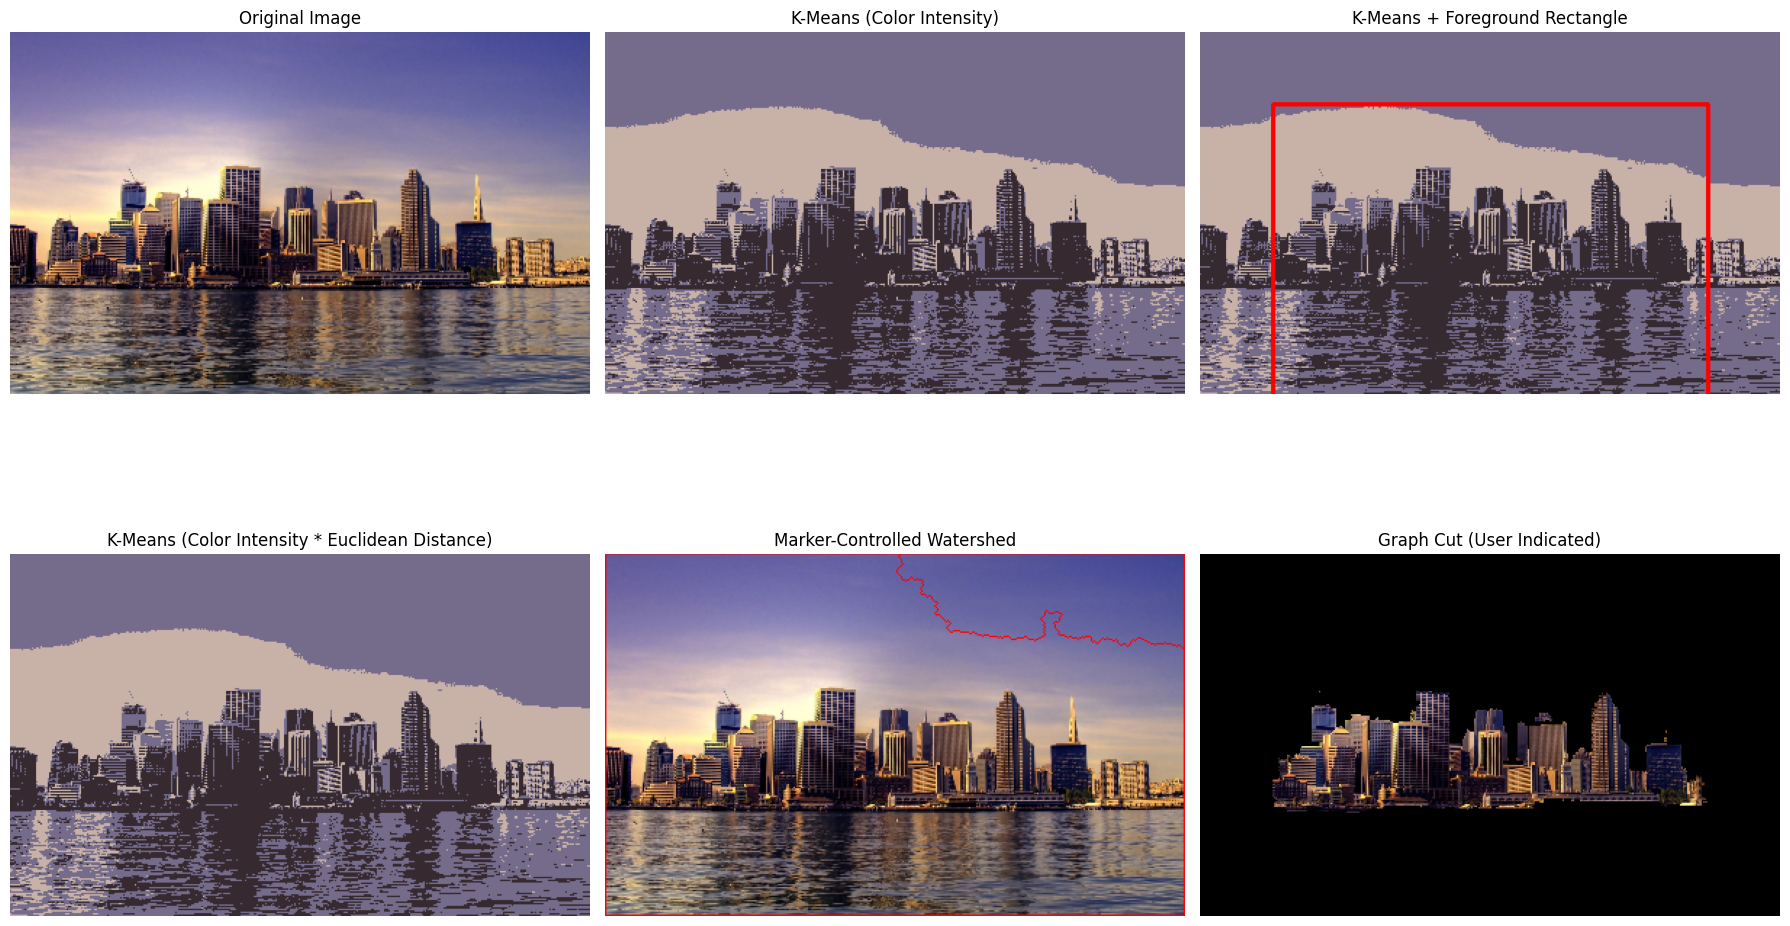

In [466]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))  # ✅ Bigger figure
ax[0, 0].imshow(image)
ax[0, 0].set_title("Original Image")

ax[0, 1].imshow(kmeans_1)
ax[0, 1].set_title("K-Means (Color Intensity)")

ax[0, 2].imshow(kmeans_2)
ax[0, 2].set_title("K-Means + Foreground Rectangle")

ax[1, 0].imshow(kmeans_3)
ax[1, 0].set_title("K-Means (Color Intensity * Euclidean Distance)")

ax[1, 1].imshow(watershed_result)
ax[1, 1].set_title("Marker-Controlled Watershed")

# For the graph cut result, since it now has an alpha channel, display only RGB
ax[1, 2].imshow(cv2.cvtColor(graph_cut_result, cv2.COLOR_RGBA2RGB))
ax[1, 2].set_title("Graph Cut (User Indicated)")

for a in ax.flatten():
    a.axis("off")

plt.tight_layout()  # ✅ Better spacing
plt.show()

In [467]:
import os
# Define folder to save images
save_directory = "your output folder"
os.makedirs(save_directory, exist_ok=True)

graph_cut_save_path = os.path.join(save_directory, "bg_removed.png")
graph_cut_bgra = cv2.cvtColor(graph_cut_result, cv2.COLOR_RGBA2BGRA)
cv2.imwrite(graph_cut_save_path, graph_cut_bgra)

True